In [1]:
import xarray as xr
import double_slit as ds
from double_slit import ds_para
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Import data
"""
data=xr.open_dataset("y_data.nc")
data

<xarray.Dataset>
Dimensions:                (dim_1: 450, time: 7803)
Coordinates:
  * time                   (time) float64 1.634e+09 1.634e+09 ... 1.634e+09
Dimensions without coordinates: dim_1
Data variables:
    tms_diag_y_projection  (time, dim_1) float64 ...

In [3]:
"""
Block for analyzing the timestamps 
We see that on average between 2 timestamps 3.6s pass. 
"""
a=np.array(data.time)[1:]-np.array(data.time)[:-1]
print(np.max(a),np.min(a),np.mean(a))

43.01044154167175 1.3880164623260498 3.5687937587385026


In [4]:
x0_pred=ds_para(intensity=1000,
                sx=0.07,
                x0=225,
                offset=450,
                a2=1.6,
                a3=0.2,
                phase=3.15)

Regressor = ds.double_slit_reg(x0_pred=x0_pred)

x=np.arange(450)
y=data.tms_diag_y_projection[4,:]
Regressor.fit(x,y)

ds_para(intensity=2390.8345717461007, sx=0.012738042816677926, x0=206.0289013643262, offset=171.41599809148644, a2=-0.8418428679062707, a3=0.1991244454392781, phase=4.371689233536784e-14)

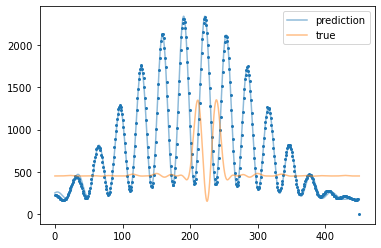

In [5]:
Regressor.plot_result(x,y,true_input=x0_pred)
Regressor.x

In [6]:
exact_paras=ds_para(*Regressor.x.to_array().tolist()) #remember the predicted parameters, for later
                                                      #analysis
exact_paras

ds_para(intensity=2390.8345717461007, sx=0.012738042816677926, x0=206.0289013643262, offset=171.41599809148644, a2=-0.8418428679062707, a3=0.1991244454392781, phase=4.371689233536784e-14)

In [7]:
from tqdm import tqdm
"""
Check if the x0_pred parameters work for all datapoints as good 
"""

x0_pred=ds_para(intensity=1000,         #same parameters as initial ones above
                sx=0.07,
                x0=225,
                offset=450,
                a2=1.6,
                a3=0.2,
                phase=3.15)

num_bad_pred = 0         #number of bad predictions

for i in tqdm(range(1000)):
    Regressor = ds.double_slit_reg(x0_pred=x0_pred)
    y=data.tms_diag_y_projection[i,:]
    Regressor.fit(x,y)
    if np.mean(np.abs(Regressor.predict(x)-np.array(y)))>80:
        num_bad_pred +=1

print(f"In total {num_bad_pred}/1000 got mispredicted")   #true jac: 678/1000

100%|██████████| 1000/1000 [09:51<00:00,  1.69it/s]

In total 678/1000 got mispredicted


ds_para(intensity=2355.4506762033693, sx=0.01253498441895654, x0=204.53894247318738, offset=154.9624098457393, a2=-0.0004926726549977814, a3=0.5886767577087623, phase=2.9202153893145884)


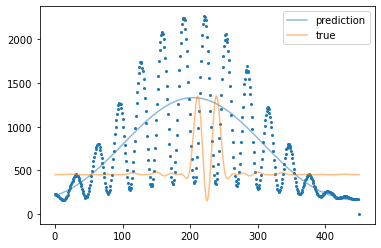

In [113]:
"""
Example for bad prediction
"""
Regressor = ds.double_slit_reg(x0_pred=x0_pred)
y=data.tms_diag_y_projection[1,:]
Regressor.fit(x,y)

Regressor.plot_result(x,y,true_input=x0_pred)


In [114]:
print(Regressor.x)

ds_para(intensity=2355.4506762033693, sx=0.01253498441895654, x0=204.53894247318738, offset=154.9624098457393, a2=-0.0004926726549977814, a3=0.5886767577087623, phase=2.9202153893145884)


We see that in alot of cases the prediction is wrong.

How will the prediction look like, if we take as x0 a parameter, that perfectly fits one datapoint?

In [9]:
num_bad_pred = 0         #number of bad predictions

for i in tqdm(range(7803)):
    Regressor = ds.double_slit_reg(x0_pred=exact_paras)
    y=data.tms_diag_y_projection[i,:]
    Regressor.fit(x,y)
        
    if np.mean(np.abs(Regressor.predict(x)-np.array(y)))>80:
        num_bad_pred += 1
        #print(i)     #to find indices with bad predictions

print(f"In total {num_bad_pred}/7803 got mispredicted")  #true jac: 82/7803

100%|██████████| 7803/7803 [09:08<00:00, 14.24it/s]

In total 82/7803 got mispredicted


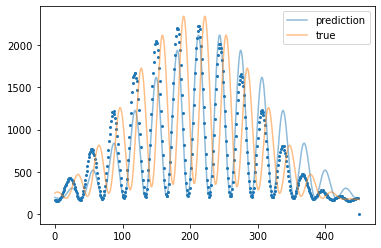

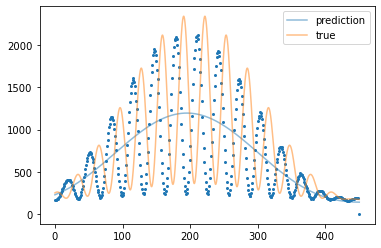

In [13]:
"""
Examples for bad prediction
"""

Regressor = ds.double_slit_reg(x0_pred=exact_paras)
y=data.tms_diag_y_projection[4743,:]
Regressor.fit(x,y)
Regressor.plot_result(x,y,true_input=exact_paras)
plt.show()

Regressor = ds.double_slit_reg(x0_pred=exact_paras)
y=data.tms_diag_y_projection[4933,:]
Regressor.fit(x,y)
Regressor.plot_result(x,y,true_input=exact_paras)
plt.show()

Now, only few wrong preictions occured. How can we get better?

1. Try a different start value
2. What happens if we change consistently set the start value to the last predicted value 

# 1: Different start value #

In [14]:
Regressor = ds.double_slit_reg(x0_pred=exact_paras)

x=np.arange(450)
y=data.tms_diag_y_projection[5100,:]   #in this index, the regressor above had problems
Regressor.fit(x,y)
new_paras = Regressor.x

num_bad_pred = 0         #number of bad predictions

for i in tqdm(range(7803)):
    Regressor = ds.double_slit_reg(x0_pred=new_paras)
    y=data.tms_diag_y_projection[i,:]
    Regressor.fit(x,y)
    
    if np.mean(np.abs(Regressor.predict(x)-np.array(y)))>80:
        num_bad_pred+=1
        #print(i)     #to find indices with bad predictions
        
print(f"In total {num_bad_pred}/7803 got mispredicted")

100%|██████████| 7803/7803 [03:18<00:00, 39.41it/s]

In total 32/7803 got mispredicted


# 2: Start value adaptation #

In [9]:
from tqdm import tqdm
Regressor = ds.double_slit_reg(x0_pred=x0_pred)

num_bad_pred = 0                           #number of bad predictions
parameters=np.zeros((7803,7))              #empty matrix, where we will store all parameter values
error_array=np.zeros((7803,))

x=np.arange(450)
y=data.tms_diag_y_projection[4,:]
Regressor.fit(x,y)

for i in tqdm(range(7803)):
    parameters[i,:]=Regressor.x.to_array()
    
    if np.mean(np.abs(Regressor.predict(x)-np.array(y)))<80:   #if prediction was good
        x0_pred=Regressor.x
    else:                             #missing: What to do if prediciton is wrong   
        print("ERROR at ",i)          #possibly need to update x0_pred
        
    Regressor = ds.double_slit_reg(x0_pred=x0_pred)
    y=data.tms_diag_y_projection[i,:]
    Regressor.fit(x,y)
    
    error_array[i]=np.mean(np.abs(Regressor.predict(x)-np.array(y)))
    
    if np.mean(np.abs(Regressor.predict(x)-np.array(y)))>80:
        num_bad_pred+=1
print(f"In total {num_bad_pred}/7803 got mispredicted")

100%|██████████| 7803/7803 [01:44<00:00, 74.56it/s]

In total 0/7803 got mispredicted


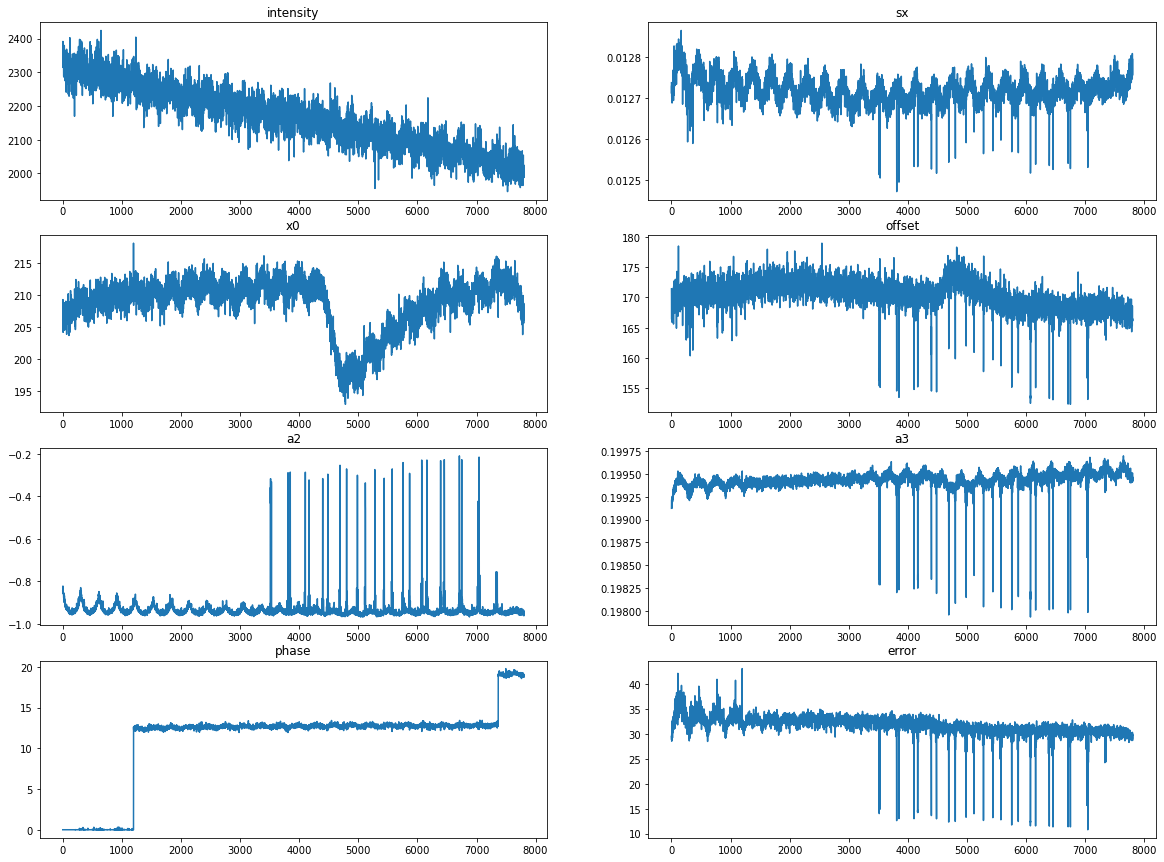

In [10]:
label_list=["intensity", "sx", "x0", "offset", "a2", "a3", "phase"]
fig, axs = plt.subplots(4, 2,figsize=(20,15))
for i in range(4):
    for j in range(2):
        if i==3 and j==1:
            break
        x=np.arange(7803)
        axs[i,j].plot(x,parameters[:,2*i+j])
        axs[i,j].title.set_text(label_list[2*i+j])
axs[3,1].plot(x,error_array)
axs[3,1].title.set_text("error")

4.680999202828119


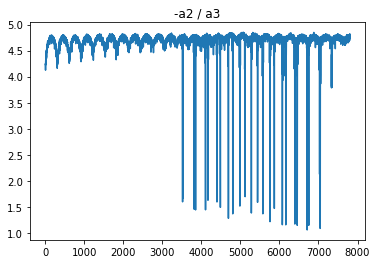

In [17]:
plt.plot(x,-parameters[:,4]/parameters[:,5])
plt.title("-a2 / a3")
print(np.mean(-parameters[:,4]/parameters[:,5]))

X0 = 205.45647426998826


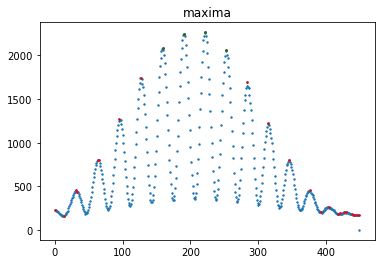

In [82]:
y=data.tms_diag_y_projection[1,:]

mask=np.r_[True, y[1:] > y[:-1]] & np.r_[y[:-1] > y[1:], True]

ind_max = np.argpartition(y[mask], -4)[-4:].values
x_max = np.arange(450)[mask][ind_max]
y_max = y[mask][ind_max]

X_max=np.ones((4,3))
X_max[:,1]=x_max
X_max[:,2]=x_max**2

W = np.linalg.inv(X_max.T@X_max)@X_max.T@(y_max.data)
print(f"X0 = {-W[1]/(2*W[2])}")

plt.scatter(np.arange(450),y,s=2)
plt.scatter((np.arange(450))[mask],y[mask],s=2,c="r")
plt.scatter(np.arange(450)[mask][ind_max],y[mask][ind_max],s=2,c="g")
plt.title("maxima")
plt.show()

100%|██████████| 7803/7803 [00:39<00:00, 195.14it/s]


1.8259252225042


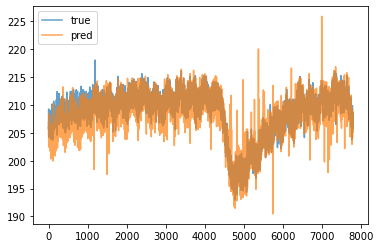

In [89]:
X0_pred=np.zeros((7803,))
for i in tqdm(range(7803)):
            
    y=data.tms_diag_y_projection[i,:]

    
    mask=np.r_[True, y[1:] > y[:-1]] & np.r_[y[:-1] > y[1:], True]

    ind_max = np.argpartition(y[mask], -4)[-4:].values
    x_max = np.arange(450)[mask][ind_max]
    y_max = y[mask][ind_max]

    X_max=np.ones((4,3))
    X_max[:,1]=x_max
    X_max[:,2]=x_max**2

    W = np.linalg.inv(X_max.T@X_max)@X_max.T@(y_max.data)
    pred_x0=-W[1]/(2*W[2])
    X0_pred[i]=pred_x0

plt.plot(np.arange(7803),parameters[:,2],label="true",alpha=0.7)
plt.plot(np.arange(7803),X0_pred,label="pred",alpha=0.7)
plt.legend()
print(np.mean(np.abs(parameters[:,2]-X0_pred)))      
        
        
        

In [90]:
print("bad inidices",np.arange(7803)[np.abs(parameters[:,2]-X0_pred)>13])      


bad inidices [1502 4985 5380 7002]


ds_para(intensity=2128.213820389838, sx=0.012585689715008432, x0=195.92411253104123, offset=162.3339399053918, a2=-0.31099008852484716, a3=0.19815923382145184, phase=2.261882180634262e-12)
Predicted  x0: 195.65440497521985
Calculated x0: 214.51171808287617


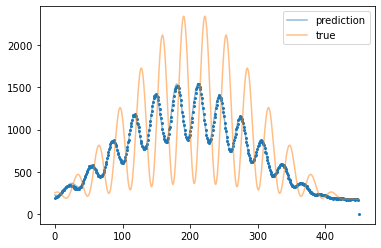

In [98]:
idx=4985 
Regressor = ds.double_slit_reg(x0_pred=exact_paras)
y=data.tms_diag_y_projection[idx,:]
x=np.arange(450)
Regressor.fit(x,y)
print(Regressor.x)
print("Predicted  x0:",parameters[idx,2])
print("Calculated x0:",X0_pred[idx])
Regressor.plot_result(x,y,true_input=exact_paras)
plt.show()

In [30]:
from tqdm import tqdm
"""
Check if the x0_pred parameters work for all datapoints as good 
"""

x0_pred=ds_para(intensity=1000,         #same parameters as initial ones above
                sx=0.07,
                x0=225,
                offset=450,
                a2=1.6,
                a3=0.2,
                phase=3.15)

initial_bad_pred = 0     #initial number of bad predictions
num_bad_pred = 0         #number of bad predictions after small changes

for i in tqdm(range(1000)):
    Regressor = ds.double_slit_reg(x0_pred=x0_pred)
    y=data.tms_diag_y_projection[i,:]
    Regressor.fit(x,y)
    if np.mean(np.abs(Regressor.predict(x)-np.array(y)))>80:
        initial_bad_pred +=1
        
        
        x0_to_change =  Regressor.x
        x0_to_change.a2 = (Regressor.x).a3*4.7
        
        
        Regressor = ds.double_slit_reg(x0_pred=x0_to_change)
        y=data.tms_diag_y_projection[i,:]
        Regressor.fit(x,y)
        if np.mean(np.abs(Regressor.predict(x)-np.array(y)))>80:
            num_bad_pred+=1
print(f"Out of initially {initial_bad_pred}/1000 bad predictions, {num_bad_pred}/1000 remained mispredicted")   

100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]

Out of initially 678/1000 bad predictions, 675/1000 remained mispredicted


In [29]:
from tqdm import tqdm
"""
Check if the x0_pred parameters work for all datapoints as good 
"""

x_bad=np.zeros((1000,))
a3_bad=np.zeros((1000,))+0.2
x_good=np.zeros((1000,))
a3_good=np.zeros((1000,))+0.2

x0_pred=ds_para(intensity=1000,         #same parameters as initial ones above
                sx=0.07,
                x0=225,
                offset=450,
                a2=1.6,
                a3=0.2,
                phase=3.15)

num_bad_pred = 0         #number of bad predictions

for i in tqdm(range(1000)):
    Regressor = ds.double_slit_reg(x0_pred=x0_pred)
    y=data.tms_diag_y_projection[i,:]
    Regressor.fit(x,y)
    if np.mean(np.abs(Regressor.predict(x)-np.array(y)))>80:
        num_bad_pred +=1
        x_bad[i]=i
        a3_bad[i]=Regressor.x.a3
    else:
        x_good[i]=i
        a3_good[i]=Regressor.x.a3

100%|██████████| 1000/1000 [02:06<00:00,  7.90it/s]


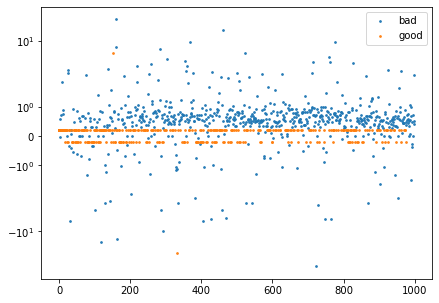

In [23]:
plt.figure(figsize=(7,5))
plt.scatter(x_bad,a3_bad,s=3,alpha=0.9,label="bad")
plt.scatter(x_good,a3_good,s=3,alpha=0.9,label="good")
plt.yscale("symlog")
plt.legend()

In [17]:
print(x_good[a3_good<-1])
print(x_good[a3_good>1])

[332.]
[152.]


40.92523471125058


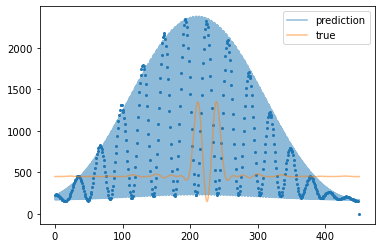

In [20]:
"""
Example for high a3 value
"""
Regressor = ds.double_slit_reg(x0_pred=x0_pred)
y=data.tms_diag_y_projection[152,:]
Regressor.fit(x,y)

Regressor.plot_result(x,y,true_input=x0_pred)
print(np.mean(np.abs(Regressor.predict(x)-np.array(y))))

In [27]:
from tqdm import tqdm
"""
Check if the x0_pred parameters work for all datapoints as good 
"""

x0_pred=ds_para(intensity=1000,         #same parameters as initial ones above
                sx=0.07,
                x0=225,
                offset=450,
                a2=1.6,
                a3=0.2,
                phase=3.15)

initial_bad_pred = 0     #initial number of bad predictions
num_bad_pred = 0         #number of bad predictions after small changes


for i in tqdm(range(1000)):
    Regressor = ds.double_slit_reg(x0_pred=x0_pred)
    y=data.tms_diag_y_projection[i,:]
    Regressor.fit(x,y)
    if np.mean(np.abs(Regressor.predict(x)-np.array(y)))>80:
        initial_bad_pred +=1
        
        x0_to_change =  Regressor.x
        x0_to_change.a3 = 0.1993
        x0_to_change.a2 = -x0_to_change.a3*4.7
        Regressor = ds.double_slit_reg(x0_pred=x0_to_change)
        y=data.tms_diag_y_projection[i,:]
        Regressor.fit(x,y)
        if np.mean(np.abs(Regressor.predict(x)-np.array(y)))>80:
            num_bad_pred+=1
print(f"Out of initially {initial_bad_pred}/1000 bad predictions, {num_bad_pred}/1000 remained mispredicted")   #true jac: 678/1000

100%|██████████| 1000/1000 [02:34<00:00,  6.47it/s]

Out of initially 678/1000 bad predictions, 5/1000 remained mispredicted


In [26]:
import pandas as pd
pd.DataFrame(parameters, columns=label_list).round(3).corr()

,intensity,sx,x0,offset,a2,a3,phase
intensity,1.000000,0.003459,0.174497,0.391164,0.075502,-0.337546,-0.686894
sx,0.003459,1.000000,-0.003722,0.105277,-0.175505,0.048251,-0.004527
x0,0.174497,-0.003722,1.000000,-0.102333,-0.022095,0.255328,0.000591
offset,0.391164,0.105277,-0.102333,1.000000,-0.510608,-0.152133,-0.126729
a2,0.075502,-0.175505,-0.022095,-0.510608,1.000000,-0.243638,-0.071467
a3,-0.337546,0.048251,0.255328,-0.152133,-0.243638,1.000000,0.255704
phase,-0.686894,-0.004527,0.000591,-0.126729,-0.071467,0.255704,1.000000


## UNCOMPLETED: Regression with Gaussian Processes ##

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter
from sklearn.gaussian_process.kernels import GenericKernelMixin
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.base import clone

import double_slit as ds


class DSKernel(GenericKernelMixin, Kernel):
    """
    A minimal (but valid) convolutional kernel for sequences of variable
    lengths."""

    def __init__(self, intensity=1000, intensity_bounds=(0, np.inf),
                       xs=0.07       , xs_bounds=(0,np.inf),
                       x0=225        , x0_bounds=(-np.inf,np.inf),
                       y0=450        , y0_bounds=(-np.inf,np.inf),
                       a2=1.6        , a2_bounds=(-np.inf,np.inf),
                       a3=0.2        , a3_bounds=(-np.inf,np.inf),
                       phase=3.15    , phase_bounds=(0,np.inf)
                ):
    
        self.intensity = intensity
        self.intensity_bounds = intensity_bounds
        self.xs = xs
        self.xs_bounds = xs_bounds
        self.x0 = x0
        self.x0_bounds = x0_bounds
        self.y0 = y0
        self.y0_bounds = y0_bounds
        self.a2 = a2
        self.a2_bounds = a2_bounds
        self.a3 = a3
        self.a3_bounds = a3_bounds
        self.phase = phase
        self.phase_bounds = phase_bounds
        
    @property
    def hyperparameter_intensity(self):
        return Hyperparameter(
            "intensity", "numeric", self.intensity_bounds
        )
    @property
    def hyperparameter_xs(self):
        return Hyperparameter(
            "xs", "numeric", self.xs_bounds
        )
    @property
    def hyperparameter_x0(self):
        return Hyperparameter(
            "x0", "numeric", self.x0_bounds
        )
    @property
    def hyperparameter_y0(self):
        return Hyperparameter(
            "y0", "numeric", self.y0_bounds
        )
    @property
    def hyperparameter_a2(self):
        return Hyperparameter(
            "a2", "numeric", self.a2_bounds
        )
    @property
    def hyperparameter_a3(self):
        return Hyperparameter(
            "a3", "numeric", self.a3_bounds
        )
    @property
    def hyperparameter_phase(self):
        return Hyperparameter(
            "phase", "numeric", self.phase_bounds
        )

    def _f(self, s1, s2):
        """
        kernel value between a pair of sequences
        """
        return ds.double_slit(s1, intensity=self.intensity, sx=self.xs, x0=self.x0, offset=self.y0, 
                              a2=self.a2, a3=self.a3, phase=self.phase)*\
               ds.double_slit(s2, intensity=self.intensity, sx=self.xs, x0=self.x0, offset=self.y0, 
                              a2=self.a2, a3=self.a3, phase=self.phase)

    def _g(self, s1, s2):
        """
        kernel derivative between a pair of sequences
        
        return sum([0.0 if c1 == c2 else 1.0 for c1 in s1 for c2 in s2])
        """
        pass
    
    def __call__(self, X, Y=None, eval_gradient=False):
        if Y is None:
            Y = X

        if eval_gradient:
            raise Exception("eval_gradient ist auf True? Ableitung noch nicht implementiert")
        else:
            return np.array([[self._f(x, y) for y in Y] for x in X])

    def diag(self, X):
        return np.array([self._f(x, x) for x in X])

    def is_stationary(self):
        return False

    def clone_with_theta(self, theta):
        cloned = clone(self)
        cloned.theta = theta
        return cloned


kernel = DSKernel()

In [14]:
"""
Regression
==========
"""

X=np.arange(450)
Y=data.tms_diag_y_projection[4,:]


gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X,Y)

z = np.linspace(0, 450, num=10*600+1)
plt.scatter(X, Y, label="training")
plt.plot(z, gp.predict(z), label="prediction")

plt.title("Regression using Gaussian processes")
plt.legend()


C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:301: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
C:\Users\Alexander\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:301: RuntimeWarning: invalid value encountered in log
  return np.log(np.vstack(bounds))


Exception: eval_gradient ist auf True? Ableitung noch nicht implementiert